In [9]:
!pip install nltk
!pip install scikit-network
!pip install numpy

In [8]:
from nltk import stem
import numpy as np
from operator import itemgetter

## Download and extract the data

From [here](https://snap.stanford.edu/data/bigdata/memetracker9/quotes_2008-08.txt.gz). Extract it on your computer (or alternatively upload it to Google Colab).

## Parsing the Memetracker data

Each line of the data is structured as a tuple (MARKER, TEXT), where the first letter of the line encodes:

- P: URL of the document
- T: time of the post (timestamp)
- Q: phrase extracted from the text of the document
- L: hyper-links in the document (links pointing to other documents on the web)

Note some documents have zero phrases or zero links. 

In [13]:
L = 4 # minimum sentence length
M = 20 # minimum frequency threshold
FILEPATH = "./quotes_2008-08.txt" # PUT YOUR FILE PATH HERE"

In [2]:
f = open(FILEPATH)
quotes = {}
MAX_LINES = 1000000
i= 0

for line in f:
    if i > MAX_LINES:
        break
    
    contents = line.strip().split("\t")
    
    if line == "\n":
        domain = None
        ts = None
    else:
        marker = contents[0]
        text = contents[1]
    
        if marker == "P":
            domain = text
        elif marker == "T":
            ts = text
        elif marker == "Q":
            splitted_text = text.split(" ")
            if len(splitted_text) >= L:
                
                if text in quotes:
                    quotes[text]["domains"].append(domain)
                    quotes[text]["timestamps"].append(ts)
                else:
                    quotes[text] = {"domains": [domain], "timestamps": [ts]}
                    
    i += 1

FileNotFoundError: [Errno 2] No such file or directory: './quotes_2008-08.txt'

Choisissez une phrase (la première, peu importe) et affichez ses noms de domaine et timestamps pour vous familiariser avec la structure de données.

Combien de phrases contient notre dataset ?

On nettoie les données initiales pour ne conserver que les phrases qui apparaissent au moins $M$ fois.

In [14]:
curated_data = []
for x in quotes:
    if len(quotes[x]["domains"]) > M:
        curated_data.append(x)
len(curated_data)

387

## Construire le graphe de phrases

On veut construire un graphe dirigé, où chaque noeud $i$ est un fragment de phrase observé dans nos données, et il existe une arête entre deux noeuds $i$ et $j$ si $i$ est inclus dans $j$. 


In [20]:
def inclusion(i, j, edit_distance=1):
    stemmer = stem.PorterStemmer()
    # écrire une fonction qui renvoie vrai si i est inclus dans j, faux sinon.
    # variante : la fonction renvoie vrai si i est inclus dans j à un mot près (ie. "this is really great" est alors inclus dans "this is great news for anyone interested in bats"
    # si vous le souhaitez, vous pouvez gagner en généralité en utilisant le stemmer défini : pour un mot, stemmer.stem(mot) vous donne sa racine, ie. stemmer.stem("eating") renvoie "eat".
    return False
    

Construisez une liste `list_edges` de tuples $(i,j,w)$, chaque tuple signifiant que les phrases i et j sont reliées (utilisez la fonction d'inclusion définie plus haut), et qu'elles apparaissent $w$ fois. Les cellules suivantes utiliseront cette liste pour construire le graphe de phrases. Vous pourrez stocker les noeuds (les phrases) dans le dictionnaire `nodes`.

In [21]:
cpt_nodes = 0
nodes = {}
edges = {}
labels = [ "a" for i in range(len(curated_data))]

for ind_i, i in enumerate(curated_data):
    i = i.split(" ")
    for ind_j, j in enumerate(curated_data):
        if i == j:
            continue
        
        j = j.split(" ")
        if len(i) < len(j):
            if inclusion(i, j):
                if not tuple(i) in nodes:
                    nodes[tuple(i)] = cpt_nodes
                    cpt_nodes += 1
                if not tuple(j) in nodes:
                    nodes[tuple(j)] = cpt_nodes
                    cpt_nodes += 1

                
                e = (nodes[tuple(i)], nodes[tuple(j)])
                if e in edges:
                    edges[e] += 1
                else:
                    edges[e] = 1
list_edges = [ (i[0], i[1], edges[i]) for i in edges ]
len(list_edges)

0

In [89]:
import sknetwork as skn
from IPython.display import SVG

In [91]:
g = skn.data.from_edge_list(list_edges, directed=True, weighted=True)
n = g.shape[0]
names = [ " ".join(x) for x in nodes.keys() ]
n

37

Si votre graphe n'est pas trop gros, vous pouvez essayer de le viasualiser :) !

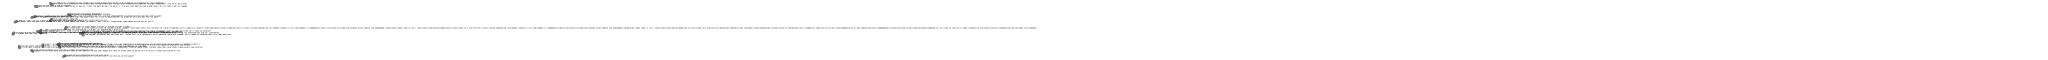

In [96]:
SVG(skn.visualization.svg_graph(g, names=names))

## Partitionner le graphe

Nous avons maintenant un graphe d'inclusion des différentes phrases de notre jeu de données, mais pas encore de _clusters_ de phrases. On sait que notre graphe a comme propriété d'être dirigé et acyclique : il y a donc des "puits", des noeuds qui n'ont aucune arête sortante. Ces puits correspondent aux phrases dans lesquelles toute une famille de phrase est incluse.

On s'attend donc à ce que nos clusters de phrases contiennent tous un seul puits. Ainsi, notre méthode sera la suivante :
- Chaque puits (= noeud de degré sortant $0$) sera dans son propre cluster,
- Pour chaque noeud $v$ relié à un puits $u$, $C(v) = C(u)$,
- Pour chaque noeud $x$ non relié à un puits, on l'assigne aléatoirement à un cluster de son voisinage.

Cela revient à assigner les noeuds aux clusters en effectuant un parcours en largeur sur le graphe transposé.

Commençons par identifier les puits, en utilisant la fonction `get_degrees` de la librairie.

In [97]:
skn.utils.get_degrees(g)
sinks = np.where(skn.utils.get_degrees(g) == 0)[0]
len(sinks)

20

Nous avons les puits. Nous pouvons donc, pour chaque puits et ses voisins, lui assigner un entier correspondant à son cluster (chacun des $k$ puits aura un entier différent, entre $0$ et $k-1$). Ensuite, nous savons que les voisins d'un puits font partie du même cluster. Une fois que l'on a assigné les voisins des puits, ceux-ci ont un indentifiant de cluster, on peut donc considérer leurs voisins, etc. Cette méthode d'exploration du graphe s'appelle un **parcours en largeur** (*Breadth-first search*).

In [22]:
from collections import deque

# implémentez ici le partitionnement du graphe de phrases

On peut visualiser le graphe à nouveau, en colorant les noeuds selon leur cluster respectif. 

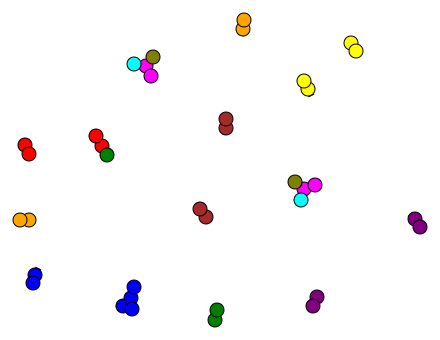

In [99]:
SVG(skn.visualization.svg_graph(g, labels=clusters))

## Identifier les _threads_ au cours du temps



In [102]:
from operator import itemgetter

threads = {}
for x in range(len(clusters)):
    c_x = clusters[x]
    
    if c_x in threads:
        threads[c_x]["domains"].extend(quotes[names[x]]["domains"])
        threads[c_x]["timestamps"].extend(quotes[names[x]]["timestamps"])
    else:
        threads[c_x] = {"domains": quotes[names[x]]["domains"], "timestamps": quotes[names[x]]["timestamps"]}
sorted([ (x, len(threads[x]["domains"]), len(threads[x]["timestamps"])) for x in threads ], key=itemgetter(1), reverse=True)[:5]

[(14, 716, 716), (0, 534, 534), (3, 406, 406), (2, 318, 318), (15, 247, 247)]

Afficher les phrases associées au _thread_ le plus fréquent.

['when i arrived in estonia last week',
 "when i arrived in estonia last week-a former soviet republic that lies just south of finland-everyone had an opinion on barack obama's speech in berlin"]

Afficher les noms de domaines les plus fréquemments associés à des phrases fréquentes.

## Complexité algorithmique

Donner une estimation de la complexité algorithmique de la méthode. Si vous avez le temps, vous pouvez proposer une version parametrée par $L$ et $M$ !